In [31]:
import tensorflow as tf
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [32]:
# size of around 400 images per class would be ideal

In [33]:
master_dataset = tf.keras.utils.image_dataset_from_directory(
    '../data/trashnet/dataset-resized',
    labels='inferred',
    image_size=(512, 256),
    batch_size=32,
    shuffle=True
)

Found 2527 files belonging to 6 classes.


In [34]:
class_names = master_dataset.class_names

In [35]:
def load_class_dataset(master_dataset, class_index, augment=False, num_samples=None):
    dataset = (master_dataset.unbatch()).filter(lambda x, y: tf.equal(y, class_index))

    if augment:
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"), # apply augmentation only if we have to make more images
            tf.keras.layers.RandomRotation(0.2),
            tf.keras.layers.RandomZoom(0.1)
        ])
        dataset = dataset.map(lambda x, y: (aug(x, training=True), y))

    if num_samples is not None:
        dataset = dataset.repeat().take(num_samples)
    return dataset.batch(32)

In [36]:
batched_dataset = []
counts = [403, 501, 482, 594, 410, 137]
target_size = 400

for i, count in enumerate(counts):
    # need to cut out some of the images
    batched_dataset.append(load_class_dataset(master_dataset, i, count < target_size, target_size))

balanced_dataset = batched_dataset[0]
for dataset in batched_dataset[1:]:
    balanced_dataset = balanced_dataset.concatenate(dataset)

In [37]:
total_samples = target_size * len(class_names)
shuffled = balanced_dataset.unbatch().shuffle(total_samples, seed=123)

In [38]:
train_dataset = (
    shuffled.take(int(0.8 * total_samples)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    shuffled.skip(int(0.8 * total_samples)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
)

In [39]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    #tf.keras.layers.RandomFlip('horizontal', input_shape=(512, 256, 3)),
    #tf.keras.layers.RandomRotation(0.2),
    #tf.keras.layers.RandomZoom(0.2),
    #tf.keras.layers.RandomBrightness(0.2),
    #tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.Rescaling(1./255, input_shape=(512, 256, 3)), # rescale the layer to fit within the 0-1 threshold
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

/Users/manntalati/Desktop/Projects/recycling_assistant/ai_recycling_assistant/tf-env/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 512, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 510, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 255, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 253, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 126, 62, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 124, 60, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 62, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 62, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 119040)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    15,237,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,266,662 (58.24 MB)

 Trainable params: 15,266,662 (58.24 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
checkpoint_dir = '../models/'

In [43]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "epoch_{epoch:02d}.weights.h5"),
    save_weights_only=True,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

In [44]:
fitted_model = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
    callbacks=[checkpoint_cb]
)

Epoch 1/5
     60/Unknown 34s 446ms/step - accuracy: 0.2225 - loss: 3.7526

/Users/manntalati/Desktop/Projects/recycling_assistant/ai_recycling_assistant/tf-env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.49583, saving model to ../models/epoch_01.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 579ms/step - accuracy: 0.2239 - loss: 3.7274 - val_accuracy: 0.4958 - val_loss: 1.3654
Epoch 2/5


2025-06-07 18:41:57.400814: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.5130 - loss: 1.2971
Epoch 2: val_accuracy improved from 0.49583 to 0.52917, saving model to ../models/epoch_02.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 473ms/step - accuracy: 0.5134 - loss: 1.2959 - val_accuracy: 0.5292 - val_loss: 1.2132
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.5955 - loss: 1.0681
Epoch 3: val_accuracy improved from 0.52917 to 0.61042, saving model to ../models/epoch_03.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 443ms/step - accuracy: 0.5961 - loss: 1.0668 - val_accuracy: 0.6104 - val_loss: 1.0112
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.7091 - loss: 0.8322
Epoch 4: val_accuracy improved from 0.61042 to 0.67708, saving model to ../models/epoch_04.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 458ms/step - accuracy: 0.7095 - loss: 0.8308 - val_accuracy: 0.6771 - val_loss: 0.9076
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.7571 - loss: 0.7039
Epoch 5: v

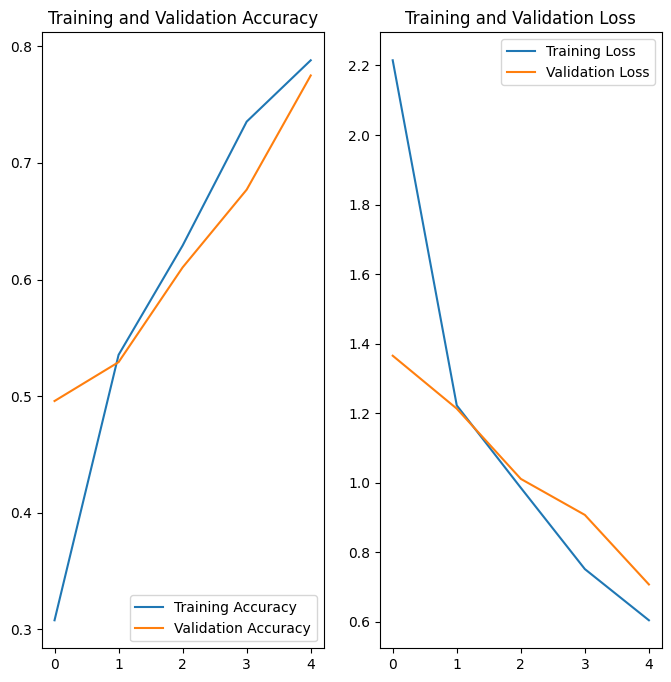

In [45]:
acc = fitted_model.history['accuracy']
val_acc = fitted_model.history['val_accuracy']

loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [46]:
img = Image.open('../data/test/cardboard_test.jpeg').resize((512, 256))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print(score.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
This image most likely belongs to cardboard with a 35.03 percent confidence.
[0.35032257 0.12975931 0.1297583  0.1297583  0.13007864 0.13032289]


In [47]:
# next step would be to hyperparameter tune and see if i can find better parameters